## Exploration

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

train.csv shape is  (1697533, 6)
test.csv shape is  (212192, 2)

        Id   ProductId          UserId  \
0   914403  B0009W5KHM   AV6QDP8Q0ONK4   
1   354887  6303079709  A2I8RXJN80A2D2   
2  1407653  B004H0M2XC  A3FHV3RV8Z12E6   
3  1377458  B003ZJ9536  A12VLTA3ZHVPUY   
4   475323  630574453X  A13NM1PES9OXVN   

                                         Summary  \
0                                  GOOD FUN FILM   
1                                   Movie Review   
2             When is it a good time to Consent?   
3                                          TRUTH   
4  Intelligent and bittersweet -- stays with you   

                                                Text  Score  
0  While most straight to DVD films are not worth...    5.0  
1  I have wanted this one for sometime, also.  I ...    5.0  
2  Actually this was a pretty darn good indie fil...    4.0  
3  Episodes 37 to 72 of the series press on in a ...    5.0  
4  I was really impressed with this movie, but wa...    3.0

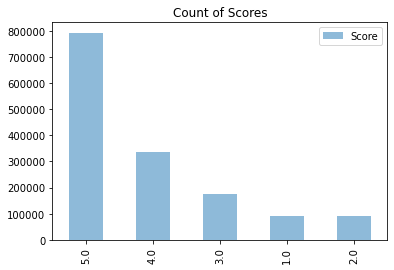

In [2]:
copy = pd.read_csv("data/train.csv")
copy.to_csv("data/train_copy.csv", index=False)

fulltrainingSet = pd.read_csv("data/train_copy.csv")
testingSet = pd.read_csv("data/test.csv")

print("train.csv shape is ", fulltrainingSet.shape)
print("test.csv shape is ", testingSet.shape)

print()

print(fulltrainingSet.head())
print()
print(testingSet.head())

print()

print(fulltrainingSet.describe())

fulltrainingSet['Score'].value_counts().plot(kind='bar', legend=True, alpha=.5)
plt.title("Count of Scores")
plt.show()

In [3]:
test_ids = testingSet['Id'].tolist()
trainingSet = fulltrainingSet[~fulltrainingSet['Id'].isin(test_ids)].copy()
print("Reduced Training Set Rows:", len(trainingSet))
print(f"Removed {len(fulltrainingSet) - len(trainingSet)} rows that were present in test set")

print(f"Subset Training Set Rows: {len(trainingSet)}")

Reduced Training Set Rows: 1485341
Removed 212192 rows that were present in test set
Subset Training Set Rows: 1485341


## Feature Extraction

In [4]:
import random
print(f"Original Training Set Rows: {len(fulltrainingSet)}")
print(f"Original Test Set Rows: {len(testingSet)}")

print(f"Reduced Training Set Rows: {len(trainingSet)}")

print("Training NaN Counts:\n", trainingSet.isna().sum())
print("\nTest NaN Counts:\n", testingSet.isna().sum())

# Calculate score distribution to use as weights
score_distribution = trainingSet['Score'].value_counts(normalize=True)
available_scores = score_distribution.index.tolist()
probabilities = score_distribution.values.tolist()

# generate random scores based on distribution
def generate_random_score():
    return random.choices(available_scores, weights=probabilities, k=1)[0]

# find and count NaNs
nan_mask = trainingSet['Score'].isna()
num_nan_scores = nan_mask.sum()
print(f"Filling {num_nan_scores} NaN scores in training set")

# for reproducibility
np.random.seed(42)

# generate weighted random scores
random_scores = [generate_random_score() for _ in range(num_nan_scores)]  # Fixed: use _ instead of *

# replace NaNs with random scores
trainingSet.loc[nan_mask, 'Score'] = random_scores

# Fill in NaN text fields
trainingSet['Text'] = trainingSet['Text'].fillna('')
trainingSet['Summary'] = trainingSet['Summary'].fillna('')

print(f"Original Training Set Rows: {len(trainingSet)}")
print(f"Original Test Set Rows: {len(testingSet)}")

Original Training Set Rows: 1697533
Original Test Set Rows: 212192
Reduced Training Set Rows: 1485341
Training NaN Counts:
 Id            0
ProductId     0
UserId        0
Summary      28
Text         54
Score         0
dtype: int64

Test NaN Counts:
 Id            0
Score    212192
dtype: int64
Filling 0 NaN scores in training set
Original Training Set Rows: 1485341
Original Test Set Rows: 212192


In [5]:
print(f"Original Training Set Rows: {len(trainingSet)}")
print(f"Original Test Set Rows: {len(testingSet)}")

print("Training NaN Counts:\n", trainingSet.isna().sum())
print("\nTest NaN Counts:\n", testingSet.isna().sum())

Original Training Set Rows: 1485341
Original Test Set Rows: 212192
Training NaN Counts:
 Id           0
ProductId    0
UserId       0
Summary      0
Text         0
Score        0
dtype: int64

Test NaN Counts:
 Id            0
Score    212192
dtype: int64


In [6]:
import re # to find patterns

# sentiment - looked at first 2000 entries
positive_words = [
    # positive words
    'good', 'unparalleled', 'fun', 'great', 'extraordinary', 'excellent', 'amazing', 
    'wonderful', 'fantatstic', 'best', 'love', 'perfect', 'recommend', '5', 'gem', 'enjoy',
    'outstanding', 'brilliant', 'superb', 'masterpiece', 'breathtaking', 
    'masterful', 'incredible', 'stunning','awesome', 'well',
    
    # + Quality descriptors
    'beautiful', 'favorite', 'loved', 'powerful', 'compelling', 'captivating', 'delightful', 
    'entertaining', 'impressive', 'engaging', 'enjoyable',
    
    # + Emotional responses
    'hilarious', 'touching', 'moving', 'thrilling', 'exciting', 'laugh', 'heart', 
    'memorable', 'classic', 'unforgettable', 'innovative', 'funny', 'thought-provoking', 
    'suspenseful', 'touching','emotional', 'powerful',
    
    # + Cinema-specific praise
    'stellar', 'oscar', 'award', 'talented', 'spectacular', 'cinematic', 'realistic',
    'authentic', 'genuine', 'sincere', 'standout', 'creative', 'original', 'unique',
    'well-acted', 'well-directed',

    'must see', 'highly recommend', 'worth watching', 'well worth', 
    'best movie', 'best film', 'loved it', 'enjoyed every', 
    'blew me away', 'pleasantly surprised',
    'one of the best', 'instant classic', 'oscar worthy',
    'beautifully shot', 'brilliant performance'
    
]

negative_words = [
    # negative words
    'bad', 'cliche', 'terrible', 'awful', 'horrible', 'worst', 'poor', 'disappointing', 
    'waste', 'avoid', 'sorry', 'lame',
    'dreadful', 'atrocious', 'abysmal', 'pathetic', 'worthless', 'disaster', 
    'catastrophe', 'unwatchable', 'unbearable','disappointed',
    
    # + Quality descriptors
    'cheap', 'mediocre', 'bland', 'weak', 'flawed', 'shallow', 'uninteresting', 
    'tedious', 'pointless', 'cliché', 'cliche',
    
    # + Emotional responses
    'hate', 'boring', 'annoying', 'stupid', 'ridiculous', 'nonsense', 'irritating', 
    'confusing', 'predictable', 'confused', 'failed', 'mess', 'painful',
    
    # + Cinema-specific criticism
    'amateur', 'amateurish','poorly', 'wooden', 'unconvincing', 'overacted', 'lousy', 'forgettable',
    'contrived', 'implausible', 'unbelievable', 'laughable', 'dull', 'slow', 'incoherent',
    'miscast',  'flat', 'low-budget', 'formulaic','gimmicky',

    'waste of time', 'waste of money', 'don\'t bother', 'not worth', 
    'stay away', 'could have been better', 'fell asleep', 
    'walked out', 'turned it off', 'worst movie', 'worst film',
    'complete disaster', 'utter disappointment', 'total mess',
    'poorly written', 'poorly directed', 'poorly acted'
]

print("Success!")

Success!


In [7]:
# helpers for text processing

# converts to lowercasse, removes punctuation, and handle multiple spaces
def clean_text(text):
    text = str(text).lower()  
    text = re.sub(r'[^\w\s]', ' ', text) 
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# count number of sentences based on punctuation
def count_sentences(text):
    text = str(text)
    return len(re.split(r'[.!?]+', text))

# count number of sentiment words in text
def count_sentiment_words(text, word_list):
    text = str(text).lower()
    
    words = set(re.findall(r'\b\w+\b', text))
    
    # Count matches with word list
    count = sum(1 for word in words if word in word_list)
    return count

# calculate sentiment ratio
def sentiment_ratio(pos, neg):
    total = pos + neg
    if total == 0:
        return 0.5  # Neutral if no sentiment words
    return pos / total

print("Success!")

Success!


In [8]:
# text data -> measurable features
def extract_features(df):
    print("Starting feature extraction...")
    
    dataset = df.copy()
    
    print("Converting text fields to strings...")
    dataset['Text'] = dataset['Text'].astype(str)
    dataset['Summary'] = dataset['Summary'].astype(str)
    
    print("Cleaning text data...")
    dataset['CleanText'] = dataset['Text'].apply(clean_text)
    dataset['CleanSummary'] = dataset['Summary'].apply(clean_text)
    print("Text cleaning complete!")
    
    print("Calculating basic length features...")
    # Basic length features
    dataset['TextLength'] = dataset['Text'].apply(len)
    dataset['SummaryLength'] = dataset['Summary'].apply(len)
    
    # Word counts
    dataset['TextWordCount'] = dataset['CleanText'].apply(lambda x: len(x.split()))
    dataset['SummaryWordCount'] = dataset['CleanSummary'].apply(lambda x: len(x.split()))
    print("Basic length features complete!")
    
    print("Calculating complexity features...")
    # Average word length (shows complexity)
    def calc_avg_word_length(x):
        words = x.split()
        if len(words) > 0:
            return sum(len(w) for w in words) / len(words)
        return 0
    
    dataset['AvgWordLength'] = dataset['CleanText'].apply(calc_avg_word_length)
    
    # Sentence count
    dataset['SentenceCount'] = dataset['Text'].apply(count_sentences)
    
    def calc_avg_words_per_sentence(row):
        return row['TextWordCount'] / max(row['SentenceCount'], 1)
    
    dataset['AvgWordsPerSentence'] = dataset.apply(calc_avg_words_per_sentence, axis=1)
    print("Complexity features complete!")
    
    return dataset

In [9]:
#fromm the dataset before
def continue_feature_extraction(dataset):
    """Continue feature extraction with punctuation and caps analysis"""
    print("Analyzing punctuation and capitalization...")
    
    # Punctuation counts and ratios
    dataset['ExclamationCount'] = dataset['Text'].apply(lambda x: x.count('!'))
    dataset['QuestionCount'] = dataset['Text'].apply(lambda x: x.count('?'))
    
    def calc_exclamation_ratio(row):
        return row['ExclamationCount'] / max(row['TextLength'], 1)
    
    def calc_question_ratio(row):
        return row['QuestionCount'] / max(row['TextLength'], 1)
    
    dataset['ExclamationRatio'] = dataset.apply(calc_exclamation_ratio, axis=1)
    dataset['QuestionRatio'] = dataset.apply(calc_question_ratio, axis=1)
    
    # ALL CAPS word count
    def count_caps_words(text):
        return sum(1 for word in str(text).split() if word.isupper() and len(word) > 1)
    
    dataset['CapsWordCount'] = dataset['Text'].apply(count_caps_words)
    
    def calc_caps_ratio(row):
        return row['CapsWordCount'] / max(row['TextWordCount'], 1)
    
    dataset['CapsRatio'] = dataset.apply(calc_caps_ratio, axis=1)
    print("Punctuation and capitalization analysis complete!")
    
    return dataset

In [10]:
# from dataset before

def extract_sentiment_features(dataset):
    """Extract sentiment-related features"""
    print("Starting sentiment analysis...")
    
    # Count positive and negative words
    print("Counting sentiment words in text...")
    dataset['TextPositiveCount'] = dataset['CleanText'].apply(
        count_sentiment_words, args=(positive_words,)
    )
    dataset['TextNegativeCount'] = dataset['CleanText'].apply(
        count_sentiment_words, args=(negative_words,)
    )
    
    print("Counting sentiment words in summary...")
    dataset['SummaryPositiveCount'] = dataset['CleanSummary'].apply(
        count_sentiment_words, args=(positive_words,)
    )
    dataset['SummaryNegativeCount'] = dataset['CleanSummary'].apply(
        count_sentiment_words, args=(negative_words,)
    )
    print("Sentiment word counting complete!")
    
    print("Calculating sentiment scores and ratios...")
    # Calculate sentiment scores and ratios
    dataset['TextSentimentScore'] = dataset['TextPositiveCount'] - dataset['TextNegativeCount']
    dataset['SummarySentimentScore'] = dataset['SummaryPositiveCount'] - dataset['SummaryNegativeCount']
    
    # density - how emotional the review is per word?
    def calc_text_sentiment_density(row):
        return row['TextSentimentScore'] / max(row['TextWordCount'], 1)
    
    def calc_summary_sentiment_density(row):
        return row['SummarySentimentScore'] / max(row['SummaryWordCount'], 1)
    
    dataset['TextSentimentDensity'] = dataset.apply(calc_text_sentiment_density, axis=1)
    dataset['SummarySentimentDensity'] = dataset.apply(calc_summary_sentiment_density, axis=1)
    
    # Weighted positive-negative ratio
    dataset['TextSentimentRatio'] = dataset.apply(
        lambda row: sentiment_ratio(row['TextPositiveCount'], row['TextNegativeCount']), axis=1
    )
    
    dataset['SummarySentimentRatio'] = dataset.apply(
        lambda row: sentiment_ratio(row['SummaryPositiveCount'], row['SummaryNegativeCount']), axis=1
    )
    print("Sentiment scores and ratios complete!")
    
    return dataset  # Return dataset with sentiment features

In [11]:
# from the dataset earlier
def extract_relationship_features(dataset):
    """Extract features that capture the relationship between summary and text"""
    print("Analyzing text-summary relationships...")
    
    # Sentiment alignment between summary and text
    def sentiment_alignment(row):
        text_sent = row['TextSentimentScore']
        summ_sent = row['SummarySentimentScore']
        
        # Both positive, both negative, or both neutral
        if (text_sent > 0 and summ_sent > 0) or (text_sent < 0 and summ_sent < 0) or (text_sent == 0 and summ_sent == 0):
            return 1
        # One positive, one negative
        elif (text_sent > 0 and summ_sent < 0) or (text_sent < 0 and summ_sent > 0):
            return -1
        # One neutral, one not
        else:
            return 0
    
    dataset['SentimentAlignment'] = dataset.apply(sentiment_alignment, axis=1)
    
    # Summary-Text length ratio
    def calc_summary_text_ratio(row):
        return row['SummaryLength'] / max(row['TextLength'], 1)
    
    dataset['SummaryTextLengthRatio'] = dataset.apply(calc_summary_text_ratio, axis=1)
    
    # Content word overlap between summary and text
    def content_word_overlap(row):

        common_stopwords = {'the', 'and', 'a', 'to', 'of', 'in', 'is', 'it', 'that', 'for', 'on', 'with', 'as', 'this', 'was', 'are'}
        
        summ_words = set(w for w in row['CleanSummary'].split() if w not in common_stopwords and len(w) > 2)
        text_words = set(w for w in row['CleanText'].split() if w not in common_stopwords and len(w) > 2)
        
        if len(summ_words) == 0:
            return 0
        
        # Calculate overlap
        overlap_count = len(summ_words.intersection(text_words))
        return overlap_count / len(summ_words)
    
    dataset['SummaryTextOverlap'] = dataset.apply(content_word_overlap, axis=1)
    print("Text-summary relationship analysis complete!")
    
    return dataset

In [12]:
def add_user_product_features(dataset, user_stats=None, product_stats=None, is_training=True):
    print("Adding user and product statistics...")
    
    # Initialize return variables if they weren't passed in
    if user_stats is None:
        user_stats = {}
    if product_stats is None:
        product_stats = {}
    
    # If we're in training, calculate statistics
    if is_training:
        # Calculate user statistics from training data
        if 'UserId' in dataset.columns and dataset['UserId'].notna().any() and 'Score' in dataset.columns:
            user_scores = dataset[dataset['Score'].notna()].groupby('UserId')['Score']
            user_avg_ratings = user_scores.mean().to_dict()
            user_rating_var = user_scores.std().fillna(0).to_dict()
            user_counts = dataset['UserId'].value_counts().to_dict()
            
            # Store for later use with test data
            user_stats = {
                'avg_ratings': user_avg_ratings,
                'rating_var': user_rating_var,
                'counts': user_counts
            }
        
        # Calculate product statistics from training data
        if 'ProductId' in dataset.columns and dataset['ProductId'].notna().any() and 'Score' in dataset.columns:
            product_scores = dataset[dataset['Score'].notna()].groupby('ProductId')['Score']
            product_avg = product_scores.mean().to_dict()
            product_var = product_scores.std().fillna(0).to_dict()
            product_counts = dataset['ProductId'].value_counts().to_dict()
            
            # Store for later use with test data
            product_stats = {
                'avg_ratings': product_avg,
                'rating_var': product_var,
                'counts': product_counts
            }
    
    # Apply statistics (either from this call or passed in from training)
    if user_stats and 'avg_ratings' in user_stats and 'UserId' in dataset.columns:
        dataset['UserAvgRating'] = dataset['UserId'].map(user_stats['avg_ratings']).fillna(3.0)
        dataset['UserRatingVar'] = dataset['UserId'].map(user_stats['rating_var']).fillna(1.0)
        dataset['UserReviewCount'] = dataset['UserId'].map(user_stats['counts']).fillna(1)
        print("User statistics added!")
    else:
        # Add default values if no stats are available
        if 'UserId' in dataset.columns:
            dataset['UserAvgRating'] = 3.0
            dataset['UserRatingVar'] = 1.0
            dataset['UserReviewCount'] = 1
            print("Default user statistics added")
    
    if product_stats and 'avg_ratings' in product_stats and 'ProductId' in dataset.columns:
        dataset['ProductAvgRating'] = dataset['ProductId'].map(product_stats['avg_ratings']).fillna(3.0)
        dataset['ProductRatingVar'] = dataset['ProductId'].map(product_stats['rating_var']).fillna(1.0)
        dataset['ProductReviewCount'] = dataset['ProductId'].map(product_stats['counts']).fillna(1)
        print("Product statistics added!")
    else:
        # Add default values if no stats are available
        if 'ProductId' in dataset.columns:
            dataset['ProductAvgRating'] = 3.0
            dataset['ProductRatingVar'] = 1.0
            dataset['ProductReviewCount'] = 1
            print("Default product statistics added")
    
    return dataset, user_stats, product_stats

In [13]:
def finalize_features(dataset):
    
    print("Calculating complexity score...")
    # Feature combining multiple aspects (complexity score)
    def calc_complexity_score(row):
        return (
            row['AvgWordLength'] * 0.5 + 
            row['AvgWordsPerSentence'] * 0.3 + 
            min(row['TextLength'] / 1000, 1) * 0.2
        )
    
    dataset['ComplexityScore'] = dataset.apply(calc_complexity_score, axis=1)
    
    # Add combined sentiment-complexity feature
    dataset['SentimentComplexityScore'] = dataset['TextSentimentRatio'] * dataset['ComplexityScore']
    
    # Clean up intermediate columns
    print("Cleaning up intermediate columns...")
    columns_to_drop = ['CleanText', 'CleanSummary']
    
    # if neededd
    id_text_columns = ['Text', 'Summary']
    
    # Only drop columns that exist
    columns_to_drop.extend([col for col in id_text_columns if col in dataset.columns])
    
    final_features = dataset.drop(columns_to_drop, axis=1, errors='ignore')
    
    print("Feature extraction complete! Total features:", len(final_features.columns))
    return final_features

In [14]:
def extract_all_features(df, input_user_stats=None, input_product_stats=None, is_training=True):
    """Run the complete feature extraction pipeline"""
    print("\n=== STARTING COMPLETE FEATURE EXTRACTION PIPELINE ===\n")
    
    dataset = extract_features(df)
    
    dataset = continue_feature_extraction(dataset)
    
    dataset = extract_sentiment_features(dataset)
    
    dataset = extract_relationship_features(dataset)
    
    dataset, output_user_stats, output_product_stats = add_user_product_features(
        dataset, 
        user_stats=input_user_stats,
        product_stats=input_product_stats,
        is_training=is_training
    )
    
    final_features = finalize_features(dataset)
    
    # Handle infinities and NaNs
    print("Handling missing values and infinities...")
    final_features = final_features.replace([np.inf, -np.inf], np.nan).fillna(0)
    
    print(f"Final dataset shape: {final_features.shape}")
    print("\n=== FEATURE EXTRACTION PIPELINE COMPLETED SUCCESSFULLY ===\n")
    
    return final_features, output_user_stats, output_product_stats

In [15]:
train_features, user_stats, product_stats = extract_all_features(trainingSet, is_training=True)


=== STARTING COMPLETE FEATURE EXTRACTION PIPELINE ===

Starting feature extraction...
Converting text fields to strings...
Cleaning text data...
Text cleaning complete!
Calculating basic length features...
Basic length features complete!
Calculating complexity features...
Complexity features complete!
Analyzing punctuation and capitalization...
Punctuation and capitalization analysis complete!
Starting sentiment analysis...
Counting sentiment words in text...
Counting sentiment words in summary...
Sentiment word counting complete!
Calculating sentiment scores and ratios...
Sentiment scores and ratios complete!
Analyzing text-summary relationships...
Text-summary relationship analysis complete!
Adding user and product statistics...
User statistics added!
Product statistics added!
Calculating complexity score...
Cleaning up intermediate columns...
Feature extraction complete! Total features: 38
Handling missing values and infinities...
Final dataset shape: (1485341, 38)

=== FEATURE EXT

In [16]:
test_ids = testingSet['Id']

print("Columns in train_features:", train_features.columns.tolist())

# drop columns
columns_to_remove = ['Id', 'ProductId', 'UserId', 'Text', 'Summary', 'Score']
X_meta = train_features.copy()
for col in columns_to_remove:
    if col in X_meta.columns:
        X_meta.drop(col, axis=1, inplace=True)
y = trainingSet['Score']

print(f"Original Training Set Rows: {len(trainingSet)}")
print(f"Original Test Set Rows: {len(testingSet)}")

Columns in train_features: ['Id', 'ProductId', 'UserId', 'Score', 'TextLength', 'SummaryLength', 'TextWordCount', 'SummaryWordCount', 'AvgWordLength', 'SentenceCount', 'AvgWordsPerSentence', 'ExclamationCount', 'QuestionCount', 'ExclamationRatio', 'QuestionRatio', 'CapsWordCount', 'CapsRatio', 'TextPositiveCount', 'TextNegativeCount', 'SummaryPositiveCount', 'SummaryNegativeCount', 'TextSentimentScore', 'SummarySentimentScore', 'TextSentimentDensity', 'SummarySentimentDensity', 'TextSentimentRatio', 'SummarySentimentRatio', 'SentimentAlignment', 'SummaryTextLengthRatio', 'SummaryTextOverlap', 'UserAvgRating', 'UserRatingVar', 'UserReviewCount', 'ProductAvgRating', 'ProductRatingVar', 'ProductReviewCount', 'ComplexityScore', 'SentimentComplexityScore']
Original Training Set Rows: 1485341
Original Test Set Rows: 212192


In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack, csr_matrix

# TF-IDF Vectorization
print("Fitting TF-IDF...")
text_tfidf = TfidfVectorizer(max_features=300, ngram_range=(1,1), stop_words='english')
print("-----")
summary_tfidf = TfidfVectorizer(max_features=200, ngram_range=(1, 1), stop_words='english')

print("-----")
text_features = text_tfidf.fit_transform(trainingSet['Text'])
print("-----")
summary_features = summary_tfidf.fit_transform(trainingSet['Summary'])
print("-----")
# Combine all features
X = hstack([csr_matrix(X_meta.values), text_features, summary_features])
print(f"Final training features shape: {X.shape}")


Fitting TF-IDF...
-----
-----
-----
-----
Final training features shape: (1485341, 534)


In [18]:
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

## Creating your model

In [19]:
import pickle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_spli
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, classification_report
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

In [20]:
print("Setting up model training...")

# Split training set into training and testing set
X_train, X_test, Y_train, Y_test = train_test_split(
    X, y,
    test_size=0.25,
    random_state=42
)

# Convert sparse matrices to dense arrays if needed
if hasattr(X_train, 'toarray'):
    X_train = X_train.toarray()
    X_test = X_test.toarray()


print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")
print("Model training setup complete!")

Setting up model training...
Training data shape: (1114005, 534)
Testing data shape: (371336, 534)
Model training setup complete!


In [21]:
from sklearn.feature_selection import SelectKBest, f_classif

selector = SelectKBest(f_classif, k=100)  # Select top 100 features
X_train_selected = selector.fit_transform(X_train, Y_train)
X_test_selected = selector.transform(X_test)

print(f"Selected features shape: {X_train_selected.shape}")

Selected features shape: (1114005, 100)


In [22]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=90)
X_train_reduced = svd.fit_transform(X_train_selected)
X_test_reduced = svd.transform(X_test_selected)

In [23]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_reduced)
X_test_scaled = scaler.transform(X_test_reduced)


=== MODEL TRAINING AND EVALUATION ===


Training Decision Tree with cross-validation...
Decision Tree CV Accuracy: 0.5360 (±0.0009)
Training Decision Tree on full training set...
Decision Tree Test Accuracy: 0.5401
Accuracy on training set =  1.0
Accuracy on testing set =  0.5401119202016502


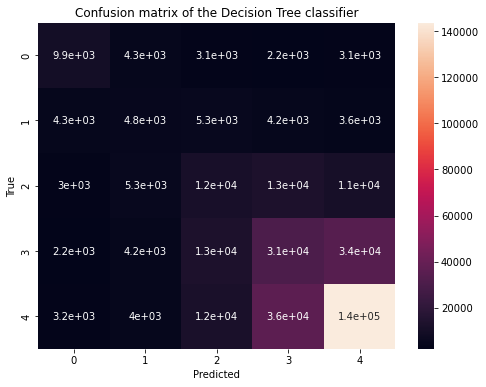


Training Random Forest with cross-validation...
Random Forest CV Accuracy: 0.6448 (±0.0010)
Training Random Forest on full training set...
Random Forest Test Accuracy: 0.6484
Accuracy on training set =  0.9999991023379607
Accuracy on testing set =  0.6484181442144042


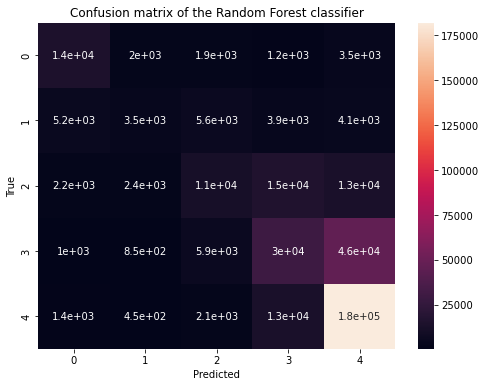


Training Logistic Regression with cross-validation...
Logistic Regression CV Accuracy: 0.6567 (±0.0006)
Training Logistic Regression on full training set...
Logistic Regression Test Accuracy: 0.6571
Accuracy on training set =  0.6569521680782402
Accuracy on testing set =  0.6571326238231683


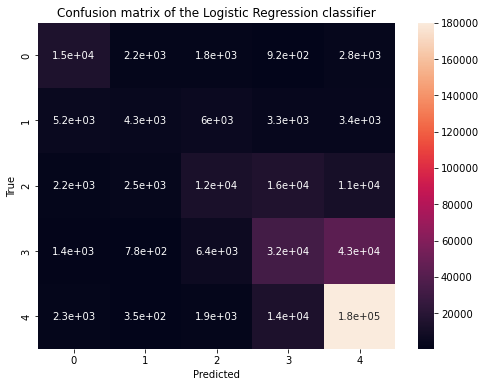


Training Linear SVC with cross-validation...
Linear SVC CV Accuracy: 0.6334 (±0.0007)
Training Linear SVC on full training set...


KeyboardInterrupt: 

In [24]:
print("\n=== MODEL TRAINING AND EVALUATION ===\n")
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC, LinearSVC

# Define models for evaluation
models = {
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42, n_jobs=-1),
    'Logistic Regression': LogisticRegression(max_iter=1000, multi_class='multinomial', random_state=42),
    'Linear SVC': LinearSVC(random_state=42, dual=False, max_iter=2000)
}

# Train and evaluate each model with cross-validation
cv_results = {}
model_objects = {}

for name, model in models.items():
    print(f"\nTraining {name} with cross-validation...")
    
    # Perform cross-validation
    scores = cross_val_score(model, X_train_scaled, Y_train, cv=cv, scoring='accuracy')
    cv_results[name] = scores  # This is just an array, not a dictionary
    
    print(f"{name} CV Accuracy: {scores.mean():.4f} (±{scores.std():.4f})")
    
    # Train model on full training data
    print(f"Training {name} on full training set...")
    model.fit(X_train_scaled, Y_train)
    model_objects[name] = model
    
    # Evaluate on test set
    test_pred = model.predict(X_test_scaled)
    test_accuracy = accuracy_score(Y_test, test_pred)
    print(f"{name} Test Accuracy: {test_accuracy:.4f}")
    
    # Evaluation
    Y_train_pred = model.predict(X_train_scaled)
    print("Accuracy on training set = ", accuracy_score(Y_train, Y_train_pred))
    Y_test_pred = model.predict(X_test_scaled)
    print("Accuracy on testing set = ", accuracy_score(Y_test, Y_test_pred))
    # Plot a confusion matrix
    cm = confusion_matrix(Y_test, Y_test_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True)
    plt.title(f'Confusion matrix of the {name} classifier')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Find best model based on cross-validation performance (fixed version)
best_model_name = max(cv_results, key=lambda k: cv_results[k].mean())
best_model = model_objects[best_model_name]
print(f"\nBest model by CV: {best_model_name} with mean accuracy {cv_results[best_model_name].mean():.4f}")

In [ ]:
# Store test accuracies for comparison
test_accuracies = {
    name: accuracy_score(Y_test, model.predict(X_test_scaled)) 
    for name, model in model_objects.items()
}

# Find best model on test set
best_test_model_name = max(test_accuracies, key=test_accuracies.get)
print(f"\nBest model on test set: {best_test_model_name} with accuracy {test_accuracies[best_test_model_name]:.4f}")

# Fine Tuning

In [ ]:
# # FOREVER

# # Fine-tuning the Best Model
# print(f"\nFine-tuning {best_model_name} model...")

# if best_model_name == 'Decision Tree':
#     print("\nFine-tuning Decision Tree model...")
#     param_grid = {
#         'max_depth': [5, 8, 10, 15],
#         'min_samples_split': [2, 5, 10, 20],
#         'min_samples_leaf': [1, 2, 4, 8]
#     }
#     base_model = DecisionTreeClassifier(random_state=42)
    
# elif best_model_name == 'Random Forest':
#     print("\nFine-tuning Random Forest model...")
#     param_grid = {
#         'n_estimators': [50, 100, 200],
#         'max_depth': [10, 15, 20, None],
#         'min_samples_split': [2, 5, 10],
#         'min_samples_leaf': [1, 2, 4]
#     }
#     base_model = RandomForestClassifier(random_state=42, n_jobs=-1)
    
# elif best_model_name == 'Logistic Regression':
#     print("\nFine-tuning Logistic Regression model...")
#     param_grid = {
#     'C': [0.1, 0.5, 1.0, 2.0, 5.0],
#     'solver': ['saga', 'lbfgs', 'newton-cg'],  # Added liblinear and saga
#     'max_iter': [3000, 5000]
# }
#     base_model = LogisticRegression(multi_class='multinomial', random_state=42)
    
# elif best_model_name == 'Linear SVC':
#     print("\nFine-tuning Linear SVC model...")
#     param_grid = {
#         'C': [0.1, 0.5, 1.0, 2.0, 5.0],
#         'class_weight': ['balanced', None],
#         'dual': [False],
#         'max_iter': [2000, 3000, 5000]
#     }
#     base_model = LinearSVC(random_state=42)

# # Perform grid search with cross-validation
# grid_search = GridSearchCV(
#     base_model,
#     param_grid,
#     cv=3,
#     scoring='accuracy',
#     n_jobs=-1,
#     verbose=1
# )

# print(f"Running grid search for {best_model_name}...")
# grid_search.fit(X_train_scaled, Y_train)

# print(f"Best parameters: {grid_search.best_params_}")
# print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

# # Update final model to the tuned version
# tuned_model = grid_search.best_estimator_

# tuned_pred = tuned_model.predict(X_test_scaled)
# tuned_accuracy = accuracy_score(Y_test, tuned_pred)
# print(f"Tuned {best_model_name} Test Accuracy: {tuned_accuracy:.4f}")

# # Add tuned model to test accuracies
# test_accuracies[f"Tuned {best_model_name}"] = tuned_accuracy

# Evaluation - Final Model

In [26]:
print("\n=== SELECTING FINAL MODEL ===\n")

# Choose the best model among all (original + tuned)
best_final_model_name = max(test_accuracies, key=test_accuracies.get)
print(f"Best overall model: {best_final_model_name} with accuracy {test_accuracies[best_final_model_name]:.4f}")

# Select final model for predictions
if best_final_model_name.startswith("Tuned"):
    final_model = tuned_model
    print(f"Using tuned {best_model_name} as final model")
else:
    final_model = model_objects[best_final_model_name]
    print(f"Using {best_final_model_name} as final model")
    
# final model evaluation
print("\n=== FINAL MODEL EVALUATION ===\n")
Y_train_pred = final_model.predict(X_train_scaled)
print("Accuracy on training set = ", accuracy_score(Y_train, Y_train_pred))
Y_test_pred = final_model.predict(X_test_scaled)
print("Accuracy on testing set = ", accuracy_score(Y_test, Y_test_pred))
# Plot a confusion matrix
cm = confusion_matrix(Y_test, Y_test_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True)
plt.title('Confusion matrix of the final classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
    
# 10. Save everything
components = {
    'final_model': final_model,
    'selector': selector,
    'text_tfidf': text_tfidf,
    'summary_tfidf': summary_tfidf,
    'feature_names': X_meta.columns.tolist()  # Save column order
}

for name, obj in components.items():
    with open(f'{name}.obj', 'wb') as f:
        pickle.dump(obj, f)

print("Pipeline trained and saved successfully!")
# print(f"Final feature shape: {X_train_scaled.shape}")


=== SELECTING FINAL MODEL ===

Best overall model: Logistic Regression with accuracy 0.6571
Using Logistic Regression as final model
Pipeline trained and saved successfully!


## Create the Kaggle submission

In [28]:
# ====== MODIFIED VERSION ======

# Load test data (no need to reload if already in memory)
testingSet = pd.read_csv("./data/test.csv")

# Create test_full by copying needed columns (more efficient than merge)
test_full = testingSet.copy()

# Get the full information for test IDs from the original training set
test_final = pd.merge(
    testingSet[['Id']],  # Only need the ID from test set
    fulltrainingSet[['Id', 'Text', 'Summary', 'ProductId', 'UserId']],  # Get all needed columns from training
    on='Id',
    how='left'
)

test_final['Text'] = test_final['Text'].fillna("")
test_final['Summary'] = test_final['Summary'].fillna("")

# Apply feature engineering (IMPORTANT: use same function as training)
print("Processing test features...")
test_features, _, _ = extract_all_features(test_final, input_user_stats=user_stats, input_product_stats=product_stats, is_training=False)

# Prepare features - ensure same columns as training
required_columns = [col for col in X_meta.columns if col in test_features.columns]
X_test_meta = test_features[required_columns]

# Transform text with PRETRAINED vectorizers
text_tfidf_test = text_tfidf.transform(test_final['Text'])
summary_tfidf_test = summary_tfidf.transform(test_final['Summary'])

# Combine features - ensure same order as training
X_test = hstack([
    csr_matrix(X_test_meta.values), 
    text_tfidf_test, 
    summary_tfidf_test
])

# Apply PRETRAINED transformations in correct order:
X_test_selected = selector.transform(X_test)  # Feature selection
X_test_reduced = svd.transform(X_test_selected)  # Dimensionality reduction
X_test_scaled = scaler.transform(X_test_reduced)  # Scaling

# Make predictions
test_predictions = final_model.predict(X_test_scaled)

# Create submission
submission = pd.DataFrame({
    'Id': testingSet['Id'],
    'Score': test_predictions
})

# Save with timestamp
from datetime import datetime
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
submission.to_csv(f'submission_{timestamp}.csv', index=False)

print("\n=== Final Checks ===")
print(f"Test features shape: {X_test_scaled.shape}")
print(f"Should match training: {X_train_scaled.shape}")
print("\nSubmission preview:")
print(submission.head())
print(f"\nSaved submission_{timestamp}.csv with {len(submission)} predictions")

# ====== END OF MODIFIED VERSION ======

Processing test features...

=== STARTING COMPLETE FEATURE EXTRACTION PIPELINE ===

Starting feature extraction...
Converting text fields to strings...
Cleaning text data...
Text cleaning complete!
Calculating basic length features...
Basic length features complete!
Calculating complexity features...
Complexity features complete!
Analyzing punctuation and capitalization...
Punctuation and capitalization analysis complete!
Starting sentiment analysis...
Counting sentiment words in text...
Counting sentiment words in summary...
Sentiment word counting complete!
Calculating sentiment scores and ratios...
Sentiment scores and ratios complete!
Analyzing text-summary relationships...
Text-summary relationship analysis complete!
Adding user and product statistics...
User statistics added!
Product statistics added!
Calculating complexity score...
Cleaning up intermediate columns...
Feature extraction complete! Total features: 37
Handling missing values and infinities...
Final dataset shape: (2

Now you can upload the `submission.csv` to kaggle